# TP2 - COMPUTER VISION I
Alumno: Diego Araujo

**Objetivo:**

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "ImageSharpnessMeasureforBlurredImagesinFrequencyDomain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del areatotal del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxMelementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica framea framedonde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los framesque no están en foco y verde para los framesdonde se detecta la condición de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [2]:
# ---------------- Paquetes a utilizar ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


import cv2 as cv

### Parte 1

In [3]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

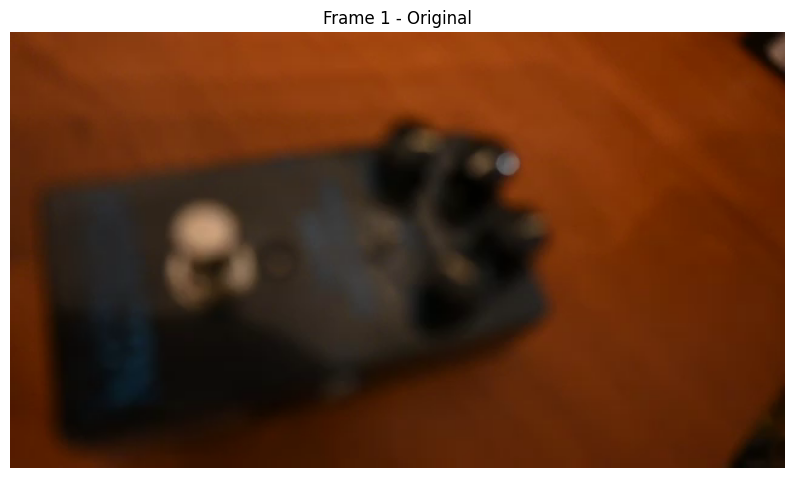

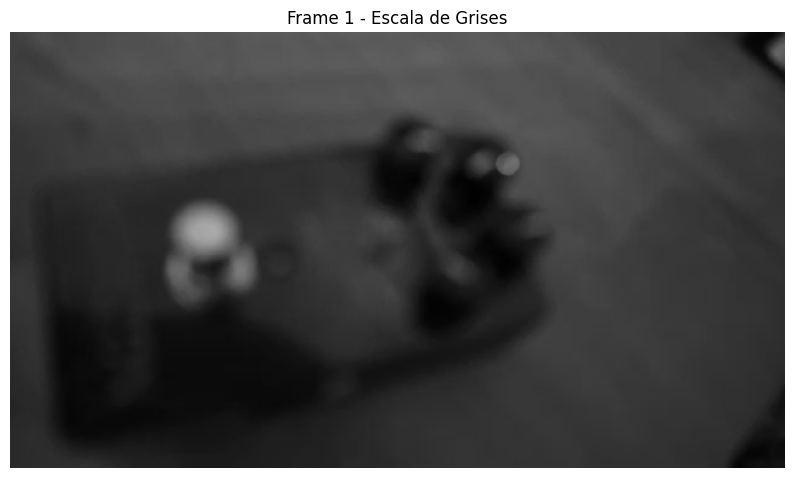

In [4]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Lee los primeros 10 frames del video
    for i in range(1):
        ret, frame = captura_video.read()
        if ret:
            # Procesamiento básico: convertir a escala de grises
            frame_gris = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            # Mostrar el frame original y el frame en escala de grises
            mostrar_imagen(frame, titulo=f'Frame {i+1} - Original')
            mostrar_imagen(frame_gris, titulo=f'Frame {i+1} - Escala de Grises')
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

In [9]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

    print(frame_height); print(frame_width)
    
    # Nuevas dimensiones (mitad del tamaño original)
    new_width = frame_width // 1
    new_height = frame_height // 1
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 35
    delay = int(1000 / fps)
    
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Mostrar el frame combinado
        cv.imshow('Video Original', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

360
640


In [6]:
# ---------------- Algoritmo para medir Calidad de Imagen ----------------

def image_quality_measure(img):

    '''
    Input:      Imagen de M x N
    Output:     Medida de la calidad de la imagen (FM)
                FM = medida del desenfoque de la imagen en el dominio de la frecuencia

    '''

    # 1) Tranformada de Fourier
    TF = np.fft.fft2(img); print(TF.dtype)

    # 2) Se lleva la baja frecuencia al origen 
    Fc = np.fft.fftshift(TF); print(Fc.dtype)
    
    # 3) Se calcula AF = abs(Fc)
    AF = np.abs(Fc); print(AF.dtype)
    
    # 4) Se calcula M = max(AF)
    M = np.max(AF); print(M.dtype)
    
    # 5) Se calcula TH = número total de píxeles en F donde valor de píxel > M/1000
    thres = M / 1000
    TH = np.sum(AF > thres); print(TH.dtype)
    
    # 6) Medida de la calidad de la imagen (FM)
    FM = TH / (img.shape[0] * img.shape[1]); print(FM.dtype)

    return FM


##### Experimento 1 - Medición sobre todo el frame

In [7]:
fm_full_frame = image_quality_measure()

TypeError: image_quality_measure() missing 1 required positional argument: 'img'

##### Experimento 2 - Medición sobre una ROI ubicada en el centro del frame (5% | 10% del total)

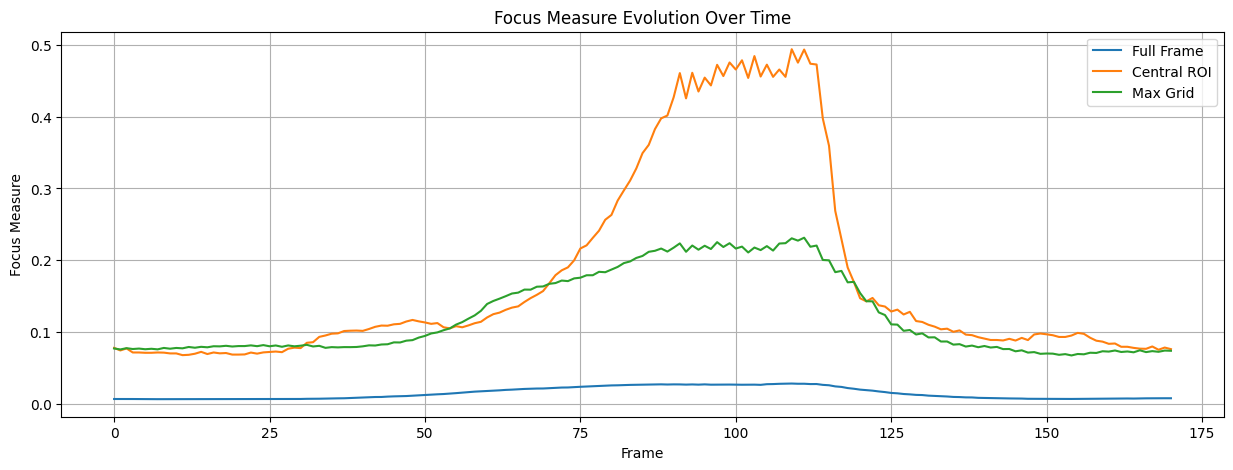

In [41]:

def process_video(video_path):
    cap = cv.VideoCapture(video_path)
    focus_measures = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Experimento 1
        fm_full = image_quality_measure(gray_frame)

        # Experimento 2
        h, w = gray_frame.shape
        roi_size = int(0.1 * h * w)  # 10% del total area de ROI
        roi_h, roi_w = int(h / 5), int(w / 5)
        roi = gray_frame[h//2 - roi_h//2:h//2 + roi_h//2, w//2 - roi_w//2:w//2 + roi_w//2]
        fm_roi = image_quality_measure(roi)

        # Experimento 3: 
        patches = [3, 7, 5]  # Diferentes tamaños de matrices N x M
        fm_grid = []
        for n in patches:
            for m in patches:
                patch_h, patch_w = h // n, w // m
                fm_patch = 0
                for i in range(n):
                    for j in range(m):
                        patch = gray_frame[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
                        fm_patch += image_quality_measure(patch)
                fm_grid.append(fm_patch / (n * m))

        # Store the results
        focus_measures.append((fm_full, fm_roi, fm_grid))

    cap.release()
    return focus_measures

def plot_focus_measures(focus_measures):
    full_focus = [fm[0] for fm in focus_measures]
    roi_focus = [fm[1] for fm in focus_measures]
    grid_focus = [max(fm[2]) for fm in focus_measures]  # Máximo grid de enfoque 

    plt.figure(figsize=(15, 5))
    plt.plot(full_focus, label='Full Frame')
    plt.plot(roi_focus, label='Central ROI')
    plt.plot(grid_focus, label='Max Grid')
    plt.xlabel('Frame')
    plt.ylabel('Focus Measure')
    plt.title('Focus Measure Evolution Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Se ejecuta
video_path = 'focus_video.mov'  # Path
focus_measures = process_video(video_path)
plot_focus_measures(focus_measures)


### Parte 2

In [ ]:
def calculate_acmo(image):
    # Pasaje a escala de grises
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Histograma
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256], density=True)
    
    # Valor de intensidad medio 
    intensity_values = np.arange(256)
    mean_intensity = np.sum(intensity_values * hist)
    
    # Calculate ACMo (Momento Central Absoluto)
    acmo = np.sum(np.abs(intensity_values - mean_intensity) * hist)
    
    return acmo

def process_video_with_acmo(video_path):
    cap = cv.VideoCapture(video_path)
    acmo_measures = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Experimento 1
        acmo_full = calculate_acmo(gray_frame)

        # Experimento 2
        h, w = gray_frame.shape
        roi_size = int(0.1 * h * w)  # Using 10% of total area as ROI
        roi_h, roi_w = int(h / 5), int(w / 5)
        roi = gray_frame[h//2 - roi_h//2:h//2 + roi_h//2, w//2 - roi_w//2:w//2 + roi_w//2]
        acmo_roi = calculate_acmo(roi)

        # Experimento 3: 
        patches = [3, 7, 5] 
        acmo_grid = []
        for n in patches:
            for m in patches:
                patch_h, patch_w = h // n, w // m
                acmo_patch = 0
                for i in range(n):
                    for j in range(m):
                        patch = gray_frame[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
                        acmo_patch += calculate_acmo(patch)
                acmo_grid.append(acmo_patch / (n * m))

        # Store the results
        acmo_measures.append((acmo_full, acmo_roi, acmo_grid))

    cap.release()
    return acmo_measures

def plot_acmo_measures(acmo_measures):
    full_acmo = [fm[0] for fm in acmo_measures]
    roi_acmo = [fm[1] for fm in acmo_measures]
    grid_acmo = [max(fm[2]) for fm in acmo_measures]  

    plt.figure(figsize=(15, 5))
    plt.plot(full_acmo, label='Full Frame')
    plt.plot(roi_acmo, label='Central ROI')
    plt.plot(grid_acmo, label='Max Grid')
    plt.xlabel('Frame')
    plt.ylabel('ACMo Measure')
    plt.title('ACMo Focus Measure Evolution Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Se ejecuta
video_path = 'focus_video.mov'  
acmo_measures = process_video_with_acmo(video_path)
plot_acmo_measures(acmo_measures)